# HW03 – 品牌關鍵詞分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import numpy as np
import re

# font
plt.rcParams['font.sans-serif'] = ['PingFang HK']
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


## 定義品牌

In [2]:
from typing import TypedDict


class BrandMatcher(TypedDict):
    brand: str
    matcher: re.Pattern


In [3]:
brands_matchers: list[BrandMatcher] = [
    {
        "brand": "Nike",
        "matcher": re.compile(r"Nike|耐吉|耐克", re.IGNORECASE)
    },
    {
        "brand": "Shock Absorber",
        "matcher": re.compile(r"Shock(?:\s*)Absorber|Shock_Absorber|SA", re.IGNORECASE)
    },
    {
        "brand": "Adidas",
        "matcher": re.compile(r"Adidas|愛迪達|addias", re.IGNORECASE)
    },
    {
        "brand": "UA",
        "matcher": re.compile(r"UA|Under Armour", re.IGNORECASE)
    },
    {
        "brand": "Triumph",
        "matcher": re.compile(r"Triumph|黛安芬", re.IGNORECASE)
    },
    {
        "brand": "Decathlon",
        "matcher": re.compile(r"Decathlon|迪卡[儂農]", re.IGNORECASE)
    },
    {
        "brand": "Mollifix",
        "matcher": re.compile(r"Mollifix", re.IGNORECASE)
    },
    {
        "brand": "Uniqio",
        "matcher": re.compile(r"Uniqio", re.IGNORECASE)
    },
    {
        "brand": "Calvin Klein",
        "matcher": re.compile(r"Calvin(.*)Klein|CK|Calvin_Klein", re.IGNORECASE)
    }
]

## Import file

In [4]:
df = pd.read_csv('PTT_運動內衣_所有資料1000.csv')

移除「公告」分類的項目

In [5]:
df = df[df['分類'] != '公告']

## 合併標題、內文變所有文

讀取 stopwords list

In [6]:
# stopwords and remove_words cleaning
import json


with open("stopwords.txt", "r") as f:
    stopwords = f.read().splitlines()

with open("remove_words.json", "r") as f:
    stopwords.extend(json.load(f))

In [7]:
df = df.replace(stopwords, '')

In [8]:
from ast import literal_eval
from typing import Any

COMFORTABLE_REGEX = re.compile('舒服|好穿|舒適')

# 清理文字中的 stopwords 和垃圾文字
def clean_stopwords(x: Any) -> str:
    x = str(x)

    # 移除 html tags
    x = re.sub(r'<[^>]*>', '', x)

    # 移除網址
    x = re.sub(r'https?://[^\s]+', '', x)

    # 移除非必要前綴
    x = re.sub(r'(新聞連結|原文連結|原文內容)[：:]', '', x)
    
    # 移除空白
    x = re.sub(r'\s*', '', x)

    # 移除停用詞
    for word in stopwords:
        x = x.replace(word, '')

    # 統一字眼
    x = COMFORTABLE_REGEX.sub('舒適', x)

    return x

# 解析留言並擷取正確內容
def comments_content_to_one_line(x: Any) -> str:
    x = str(x)

    # 發現內容是 JSON，直接解析
    try:
        evaled_content = literal_eval(x)
        
        if not isinstance(evaled_content, list):
            raise ValueError("Invalid JSON string")
        
        content = " ".join([item.get('content', '') for item in evaled_content])
        return clean_stopwords(content)
    except Exception as e:
        # 無效資料，回傳空值
        print(f"無效資料 {x}: {e}")
        return ""


df['內文_cleaned'] = (df['標題'] + "\n" + df['內文']).apply(clean_stopwords)
df['留言_cleaned'] = df['留言'].apply(comments_content_to_one_line)

df['所有文'] = (df['內文_cleaned'] + df['留言_cleaned']).str.strip()

無效資料 [{'type': '推', 'user': 'bill403777', 'content': '人畜分離政策', 'ipdatetime': '114.137.6.124 01/21 09:12'}, {'type': '推', 'user': 'seuil', 'content': '防疫人人有責', 'ipdatetime': '111.82.188.126 01/21 09:12'}, {'type': '→', 'user': 'axzs1111', 'content': '中國人與非洲豬瘟的豬隻不得入內', 'ipdatetime': '223.136.44.221 01/21 09:12'}, {'type': '→', 'user': 'SDNS', 'content': '隔離中國人就是最好的防疫政策', 'ipdatetime': '114.25.115.144 01/21 09:13'}, {'type': '→', 'user': 'hoin', 'content': '全球病毒窟支那國  世界各國應該禁止入境', 'ipdatetime': '60.248.189.97 01/21 09:13'}, {'type': '推', 'user': 'ePaper', 'content': '有預感這篇可能會上新聞', 'ipdatetime': '101.13.193.146 01/21 09:13'}, {'type': '推', 'user': 'seuil', 'content': '豬瘟禁止中國豬 人瘟禁止中國人 合理', 'ipdatetime': '111.82.188.126 01/21 09:14'}, {'type': '推', 'user': 'kerodo', 'content': '沒貼狗算客氣了', 'ipdatetime': '114.26.130.159 01/21 09:14'}, {'type': '推', 'user': 'j55888819', 'content': '但老闆同意香港人和臺灣人進店誒', 'ipdatetime': '111.251.13.124 01/21 09:14'}, {'type': '推', 'user': 'roywow', 'content': '哈哈哈 被排泄',

## 整合各品牌不一致的稱謂

In [9]:
def unify_brand_words(x: str) -> str:
    for brand_matcher in brands_matchers:
        matcher = brand_matcher['matcher']
        x = matcher.sub(brand_matcher['brand'], x)

    return x

df['所有文'] = df['所有文'].apply(unify_brand_words)

## 根據品牌分類文章

同時，移除和品牌無關的貼文

In [10]:
def brand_category(x: str) -> str | None:
    for brand_matcher in brands_matchers:
        matcher = brand_matcher['matcher']
        if matcher.search(x):
            return brand_matcher['brand']
    return None

df['品牌'] = df['所有文'].apply(brand_category)
df.dropna(subset=['品牌'], inplace=True)

## 畫出各品牌各關鍵字長條圖（一個品牌一張圖）

In [11]:
import jieba
import jieba.analyse


In [12]:
# 探勘這些文章中最常出現的幾個關鍵字

tfidf = jieba.analyse.extract_tags(" ".join(df['所有文']), topK=250, withWeight=True)
tfidf_df = pd.DataFrame(tfidf, columns=['關鍵字', 'TF-IDF'])
tfidf_df = tfidf_df.sort_values(by='TF-IDF', ascending=False)

tfidf_df.head(20)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/qj/62r8d09n5hn3nm_bdzf0dcpr0000gn/T/jieba.cache
Loading model cost 0.256 seconds.
Prefix dict has been built successfully.


,關鍵字,TF-IDF
0,Klein,0.065790
1,問題,0.058928
2,推推,0.045252
3,XD,0.035518
4,運動,0.032289
5,中國,0.029464
6,感覺,0.028657
7,ShoCalvin,0.028253
8,訓練,0.026639
9,專業,0.023813


使用 ChatGPT 從 TF-IDF 中拉出有意義的關鍵詞

https://chatgpt.com/share/680f3881-7758-8013-a6eb-a545893a307d

In [13]:
categorized_keywords = {
    '功能需求': ['支撐力', '防震', '包覆', '固定', '防滑', '調整'],
    '穿著感受': ['舒適', '柔軟', '舒壓', '貼合'],
    '材質特性': ['透氣', '排汗', '吸濕', '快乾', '無縫', '耐用', '輕量'],
    '產品設計': ['剪裁', '設計', '拉鍊', '胸墊', '尺寸'],
    '使用情境': ['運動', '健身', '訓練', '跑步', '重訓', '活動'],
    '身體部位/狀況': ['身體', '肌肉', '體重', '姿勢', '受傷', '膝蓋']
}

根據 keywords 畫出各品牌各關鍵字長條圖

品牌 Triumph 沒有關鍵字出現


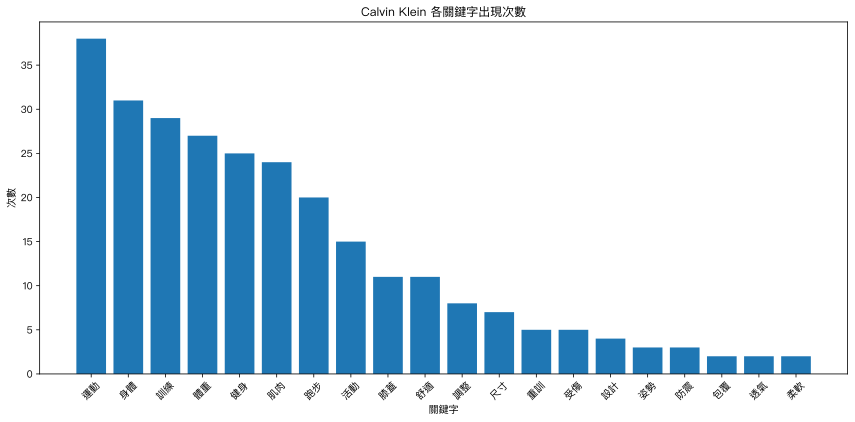

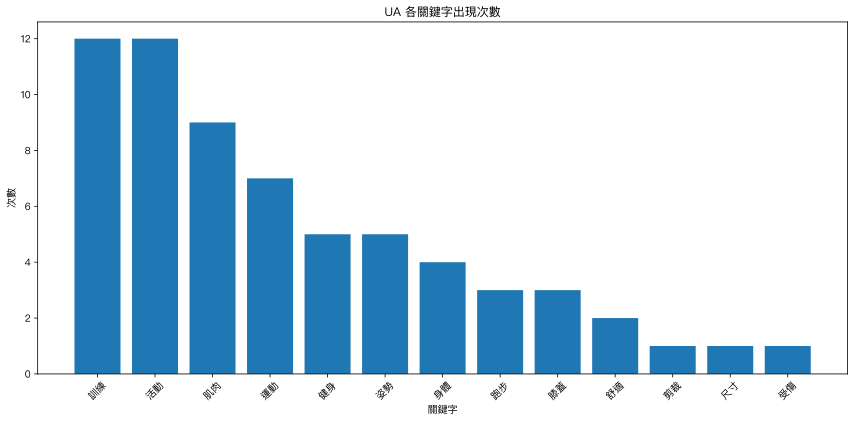

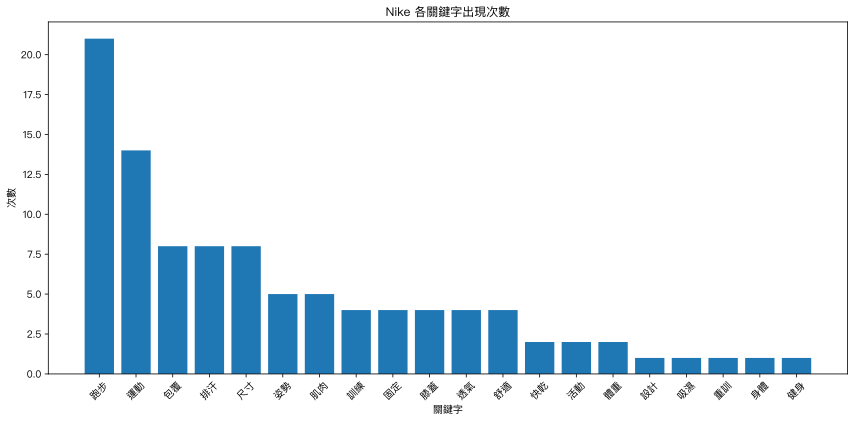

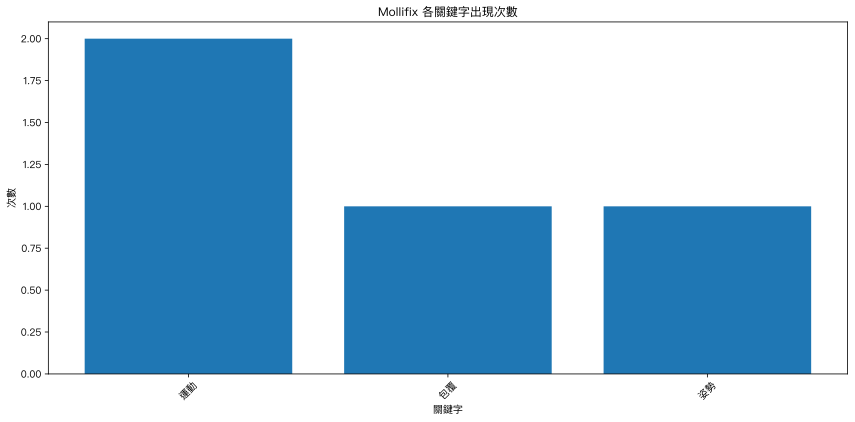

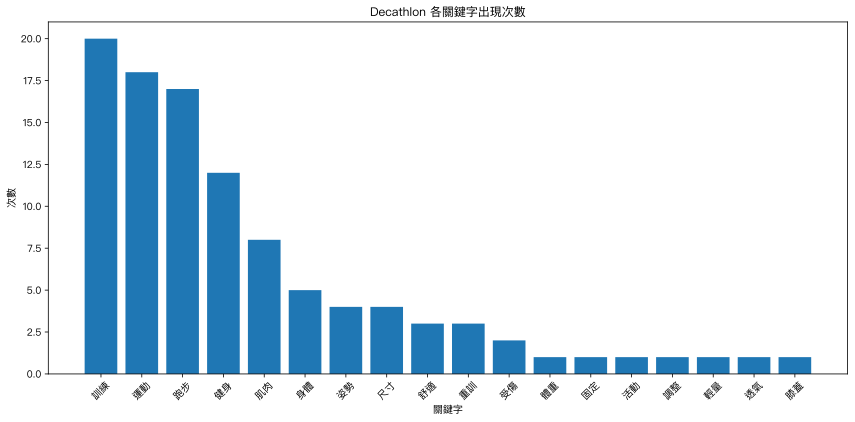

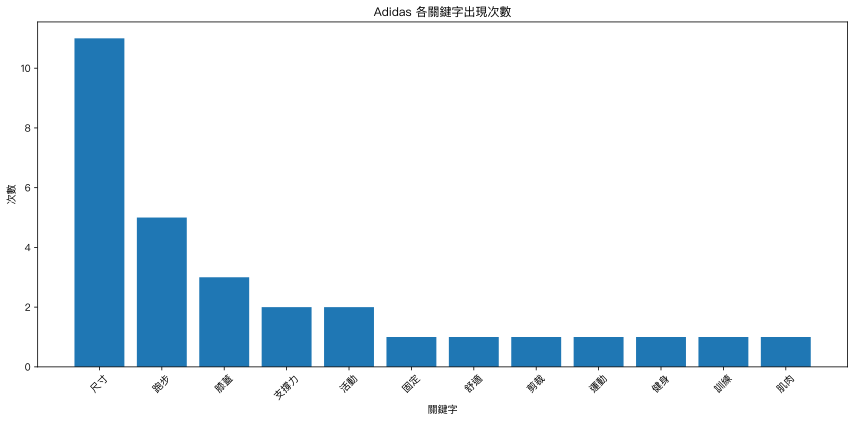

In [ ]:
from collections import Counter


all_keywords = [kw for kws in categorized_keywords.values() for kw in kws]

# 根據品牌，彙整成一個大的「所有文」
brand_article_df = {}
for brand in df['品牌'].unique():
    brand_df = df[df['品牌'] == brand]
    text = " ".join(brand_df['所有文'])

    # jieba 斷詞
    words = jieba.cut(text)
    # 統計關鍵字出現次數
    word_counter = Counter(words)
    keyword_counts = {kw: word_counter.get(kw, 0) for kw in all_keywords}

    # 如果沒有 keywords 出現，則提醒並不寫入
    if not any(keyword_counts.values()):
        print(f"品牌 {brand} 沒有關鍵字出現")
        continue

    # 寫入 brand_article_df
    brand_article_df[brand] = keyword_counts

# 畫出各品牌各關鍵字長條圖
for brand, keyword_counts in brand_article_df.items():
    drawing_df = pd.DataFrame(list(keyword_counts.items()), columns=['關鍵字', '次數'])
    drawing_df = drawing_df[drawing_df['次數'] > 0]  # 只顯示有出現的關鍵字
    drawing_df = drawing_df.sort_values(by='次數', ascending=False)
    # 畫圖
    plt.figure(figsize=(12, 6))
    plt.bar(drawing_df['關鍵字'], drawing_df['次數'])
    plt.title(f"{brand} 各關鍵字出現次數")
    plt.xlabel("關鍵字")
    plt.ylabel("次數")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 整合比較圖(一張圖)：橫向堆疊長條圖（stacked bar chart），比較所有品牌在各關鍵字的表現

品牌 Triumph 沒有關鍵字出現


<Figure size 1200x600 with 0 Axes>

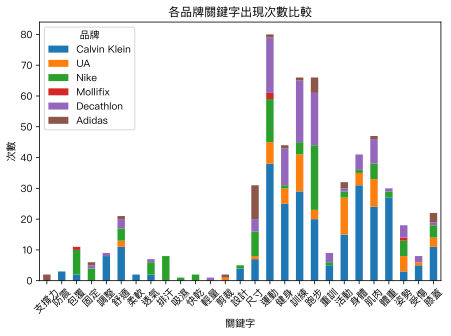

In [31]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

all_keywords = [kw for kws in categorized_keywords.values() for kw in kws]

# 根據品牌，彙整成一個大的「所有文」
brand_article_df = {}
for brand in df['品牌'].unique():
    brand_df = df[df['品牌'] == brand]
    text = " ".join(brand_df['所有文'])

    # jieba 斷詞
    words = jieba.cut(text)
    # 統計關鍵字出現次數
    word_counter = Counter(words)
    keyword_counts = {kw: word_counter.get(kw, 0) for kw in all_keywords}

    # 如果沒有 keywords 出現，則提醒並不寫入
    if not any(keyword_counts.values()):
        print(f"品牌 {brand} 沒有關鍵字出現")
        continue

    # 寫入 brand_article_df
    brand_article_df[brand] = keyword_counts

# 將資料轉換為適合繪製堆疊長條圖的格式
plot_data = pd.DataFrame(brand_article_df).fillna(0)

# 去掉沒有關鍵字的
plot_data = plot_data[plot_data.sum(axis=1) > 0]

# 畫出堆疊長條圖
plt.figure(figsize=(12, 6))

plot_data.plot(kind='bar', stacked=True)
plt.title('各品牌關鍵字出現次數比較')
plt.xlabel('關鍵字')
plt.ylabel('次數')
plt.legend(title='品牌', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()